In [1]:
%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import os
import time

from PIL import Image

env: CUDA_VISIBLE_DEVICES=2


In [2]:
# Applying Transforms to the Data
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
!gdown --id 107WLp3n77KwUgeu27Bm-aJu0mwIGgYaP

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=107WLp3n77KwUgeu27Bm-aJu0mwIGgYaP
To: /content/gingivitis.v1i.folder (2).zip
100% 17.7M/17.7M [00:00<00:00, 24.9MB/s]


In [4]:
!unzip /content/gingivitis.zip

Archive:  /content/gingivitis.zip
   creating: gingivitis.v1i.folder (1)/Dataset/
   creating: gingivitis.v1i.folder (1)/Dataset/test/
   creating: gingivitis.v1i.folder (1)/Dataset/test/Gingivitis/
  inflating: gingivitis.v1i.folder (1)/Dataset/test/Gingivitis/1-121-_jpg.rf.728d968e14e11dbd70a3f62dd65ef7c8.jpg  
  inflating: gingivitis.v1i.folder (1)/Dataset/test/Gingivitis/1-128-_jpg.rf.5d01074c41e7578b90497abc3ec2d8ce.jpg  
  inflating: gingivitis.v1i.folder (1)/Dataset/test/Gingivitis/1-159-_jpg.rf.27a13b804fe16ffffd608cac87c52fdd.jpg  
  inflating: gingivitis.v1i.folder (1)/Dataset/test/Gingivitis/1-16-_jpg.rf.2085f1cf3ac7dd38881e1cae33978cdc.jpg  
  inflating: gingivitis.v1i.folder (1)/Dataset/test/Gingivitis/1-164-_jpg.rf.c22f3dab6886ba69ce941e0fe839069e.jpg  
  inflating: gingivitis.v1i.folder (1)/Dataset/test/Gingivitis/1-175-_jpg.rf.e2e3f5d74f5d44382003f6432d6a583f.jpg  
  inflating: gingivitis.v1i.folder (1)/Dataset/test/Gingivitis/1-18-_jpg.rf.fa6f3c7c5cec6b2a7db128837a6c66

In [5]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [7]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/dataset.folder/Dataset'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

2
{0: 'Gingivitis', 1: 'Healthy'}


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size, valid_data_size, test_data_size)

393 116 56


In [9]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


In [10]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [11]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)



# Convert model to be used on GPU
resnet50 = resnet50.to(device)


In [12]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [13]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')

    return model, history, best_epoch


In [14]:
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 30
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/30
Epoch : 000, Training: Loss - 0.5501, Accuracy - 75.8270%, 
		Validation : Loss - 0.4123, Accuracy - 88.7931%, Time: 107.3500s
Epoch: 2/30
Epoch : 001, Training: Loss - 0.3595, Accuracy - 86.5140%, 
		Validation : Loss - 0.2490, Accuracy - 92.2414%, Time: 102.9095s
Epoch: 3/30
Epoch : 002, Training: Loss - 0.2955, Accuracy - 89.3130%, 
		Validation : Loss - 0.1963, Accuracy - 92.2414%, Time: 102.4803s
Epoch: 4/30
Epoch : 003, Training: Loss - 0.2666, Accuracy - 90.0763%, 
		Validation : Loss - 0.2081, Accuracy - 92.2414%, Time: 101.7264s
Epoch: 5/30
Epoch : 004, Training: Loss - 0.2720, Accuracy - 89.5674%, 
		Validation : Loss - 0.1806, Accuracy - 93.1034%, Time: 102.9369s
Epoch: 6/30
Epoch : 005, Training: Loss - 0.2175, Accuracy - 92.8753%, 
		Validation : Loss - 0.2102, Accuracy - 90.5172%, Time: 104.0154s
Epoch: 7/30
Epoch : 006, Training: Loss - 0.2451, Accuracy - 91.8575%, 
		Validation : Loss - 0.2835, Accuracy - 87.9310%, Time: 103.9717s
Epoch: 8/30
Epoch : 007, Tr

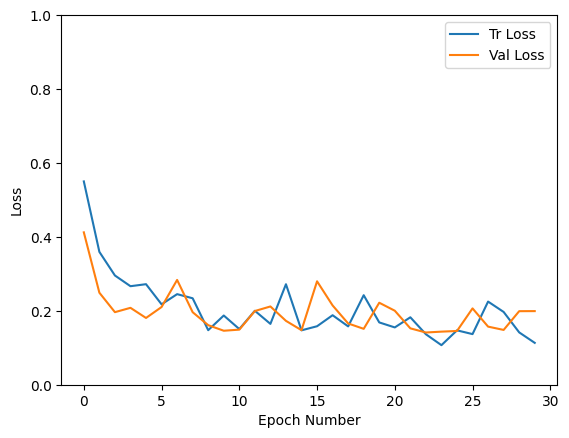

In [15]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


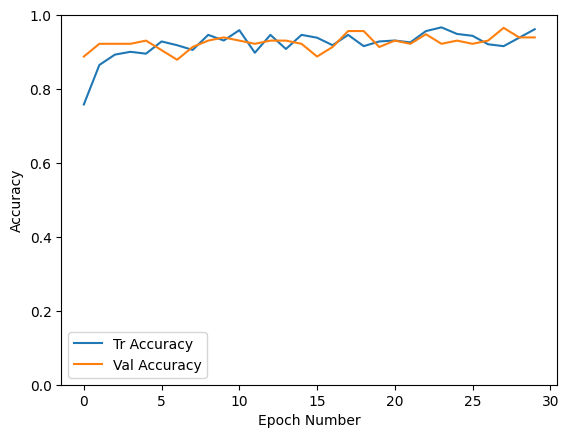

In [16]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [20]:
 def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))


In [24]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image file path
    '''

    # Load and transform the test image
    transform = image_transforms['test']
    test_image = Image.open(test_image_name).convert('RGB')  # Ensure the image is in RGB mode
    plt.imshow(test_image)
    plt.show()

    test_image_tensor = transform(test_image).unsqueeze(0)  # Add batch dimension

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.cuda()
        model = model.cuda()

    with torch.no_grad():
        out = model(test_image_tensor)
        ps = torch.exp(out)  # Assuming your model outputs log probabilities

        topk, topclass = ps.topk(3, dim=1)  # Get top 3 predictions
        for i in range(3):
            cls = idx_to_class[topclass.cpu().numpy()[0][i]]
            score = topk.cpu().numpy()[0][i]
            print(f"Prediction {i+1}: {cls}, Score: {score}")



In [26]:
# Test a particular model on a test image
dataset = '/content/dataset.folder'
model = torch.load("{}/Dataset_model_{}.pt".format(dataset, best_epoch))


# Load Data from folders
computeTestSetAccuracy(model, loss_func)


Test Batch number: 000, Test: Loss: 0.3073, Accuracy: 0.9062
Test Batch number: 001, Test: Loss: 0.0244, Accuracy: 1.0000
Test accuracy : 0.9464285714285714


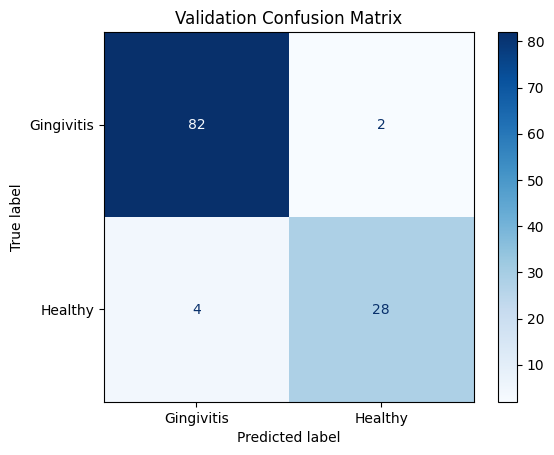

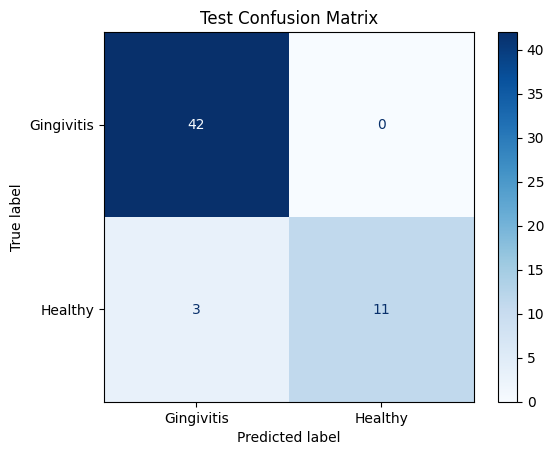

In [28]:
def evaluate_and_plot_confusion_matrix(model, dataloader, dataset_name):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataloader.dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

# Plot confusion matrices
evaluate_and_plot_confusion_matrix(model, valid_data_loader, 'Validation')
evaluate_and_plot_confusion_matrix(model, test_data_loader, 'Test')
